**Competition Objective**  
Identifing toxicity in online conversations with minimal unintended model bias.

* **Toxicity**: severe_toxicity, obscene, threat, insult, identity_attack, sexual_explicit
* A subset of comments have been labelled with a variety of **identity attributes**

Identity attributes:
* **race or ethnicity**: asian, black, jewish, latino, other_race_or_ethnicity, white
* **gender**: female, male, transgender, other_gender
* **sexual orientation**: bisexual, heterosexual, homosexual_gay_or_lesbian, other_sexual_orientation
* **religion**: atheist, buddhist, christian, hindu, muslim, other_religion
* **disability**: intellectual_or_learning_disability, other_disability, physical_disability, psychiatric_or_mental_illness

**Evaluation metrics**  
Overall AUC  
Bias AUCs
* Subgroup AUC: examples that mention the specific identity subgroup
* BPSN (Background Positive, Subgroup Negative) AUC: non-toxic examples that mention the identity and the toxic examples that do not
* BNSP (Background Negative, Subgroup Positive) AUC: toxic examples that mention the identity and the non-toxic examples that do not

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['glove840b300dtxt', 'fasttext-crawl-300d-2m', 'jigsaw-unintended-bias-in-toxicity-classification']


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
%matplotlib inline

In [9]:
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

In [10]:
train.shape, test.shape, 

((1804874, 45), (97320, 2))

In [11]:
train.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4


In [12]:
test.head(2)

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...


In [13]:
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
id                                     1804874 non-null int64
target                                 1804874 non-null float64
comment_text                           1804874 non-null object
severe_toxicity                        1804874 non-null float64
obscene                                1804874 non-null float64
identity_attack                        1804874 non-null float64
insult                                 1804874 non-null float64
threat                                 1804874 non-null float64
asian                                  405130 non-null float64
atheist                                405130 non-null float64
bisexual                               405130 non-null float64
black                                  405130 non-null float64
buddhist                               405130 non-null float64
christian                              405130 non-null float64


## EDA

In [14]:
(train['target'] > 0).mean(), (train['target'] >= 0.5).mean()

(0.2992508064274847, 0.0799690172277954)

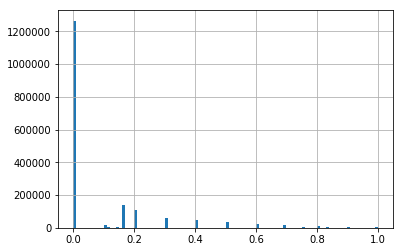

In [15]:
train['target'].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7b53f0400>,
      dtype=object)

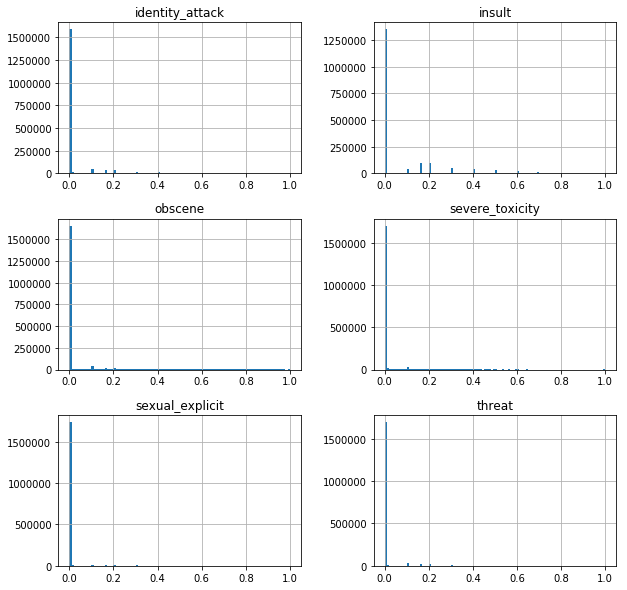

In [16]:
train[['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']].hist(bins=100, figsize=(10, 10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7b4738780>,
      dtype=object)

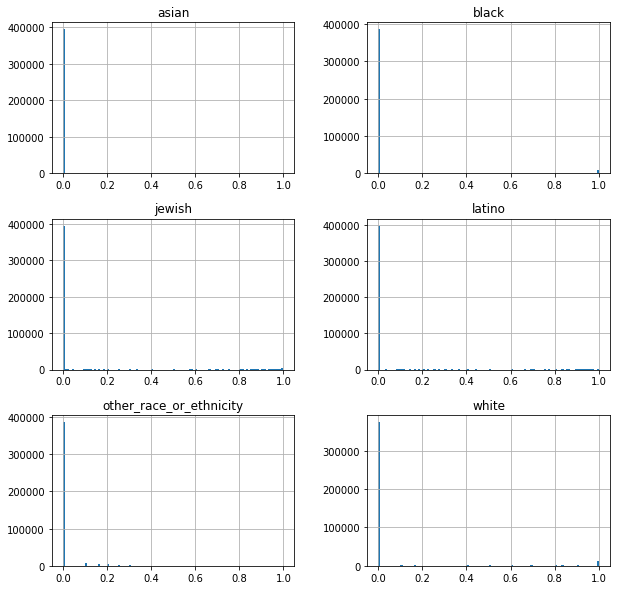

In [17]:
train[['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']].hist(bins=100, figsize=(10, 10))

Text(0.5, 0, 'Weighted Toxic')

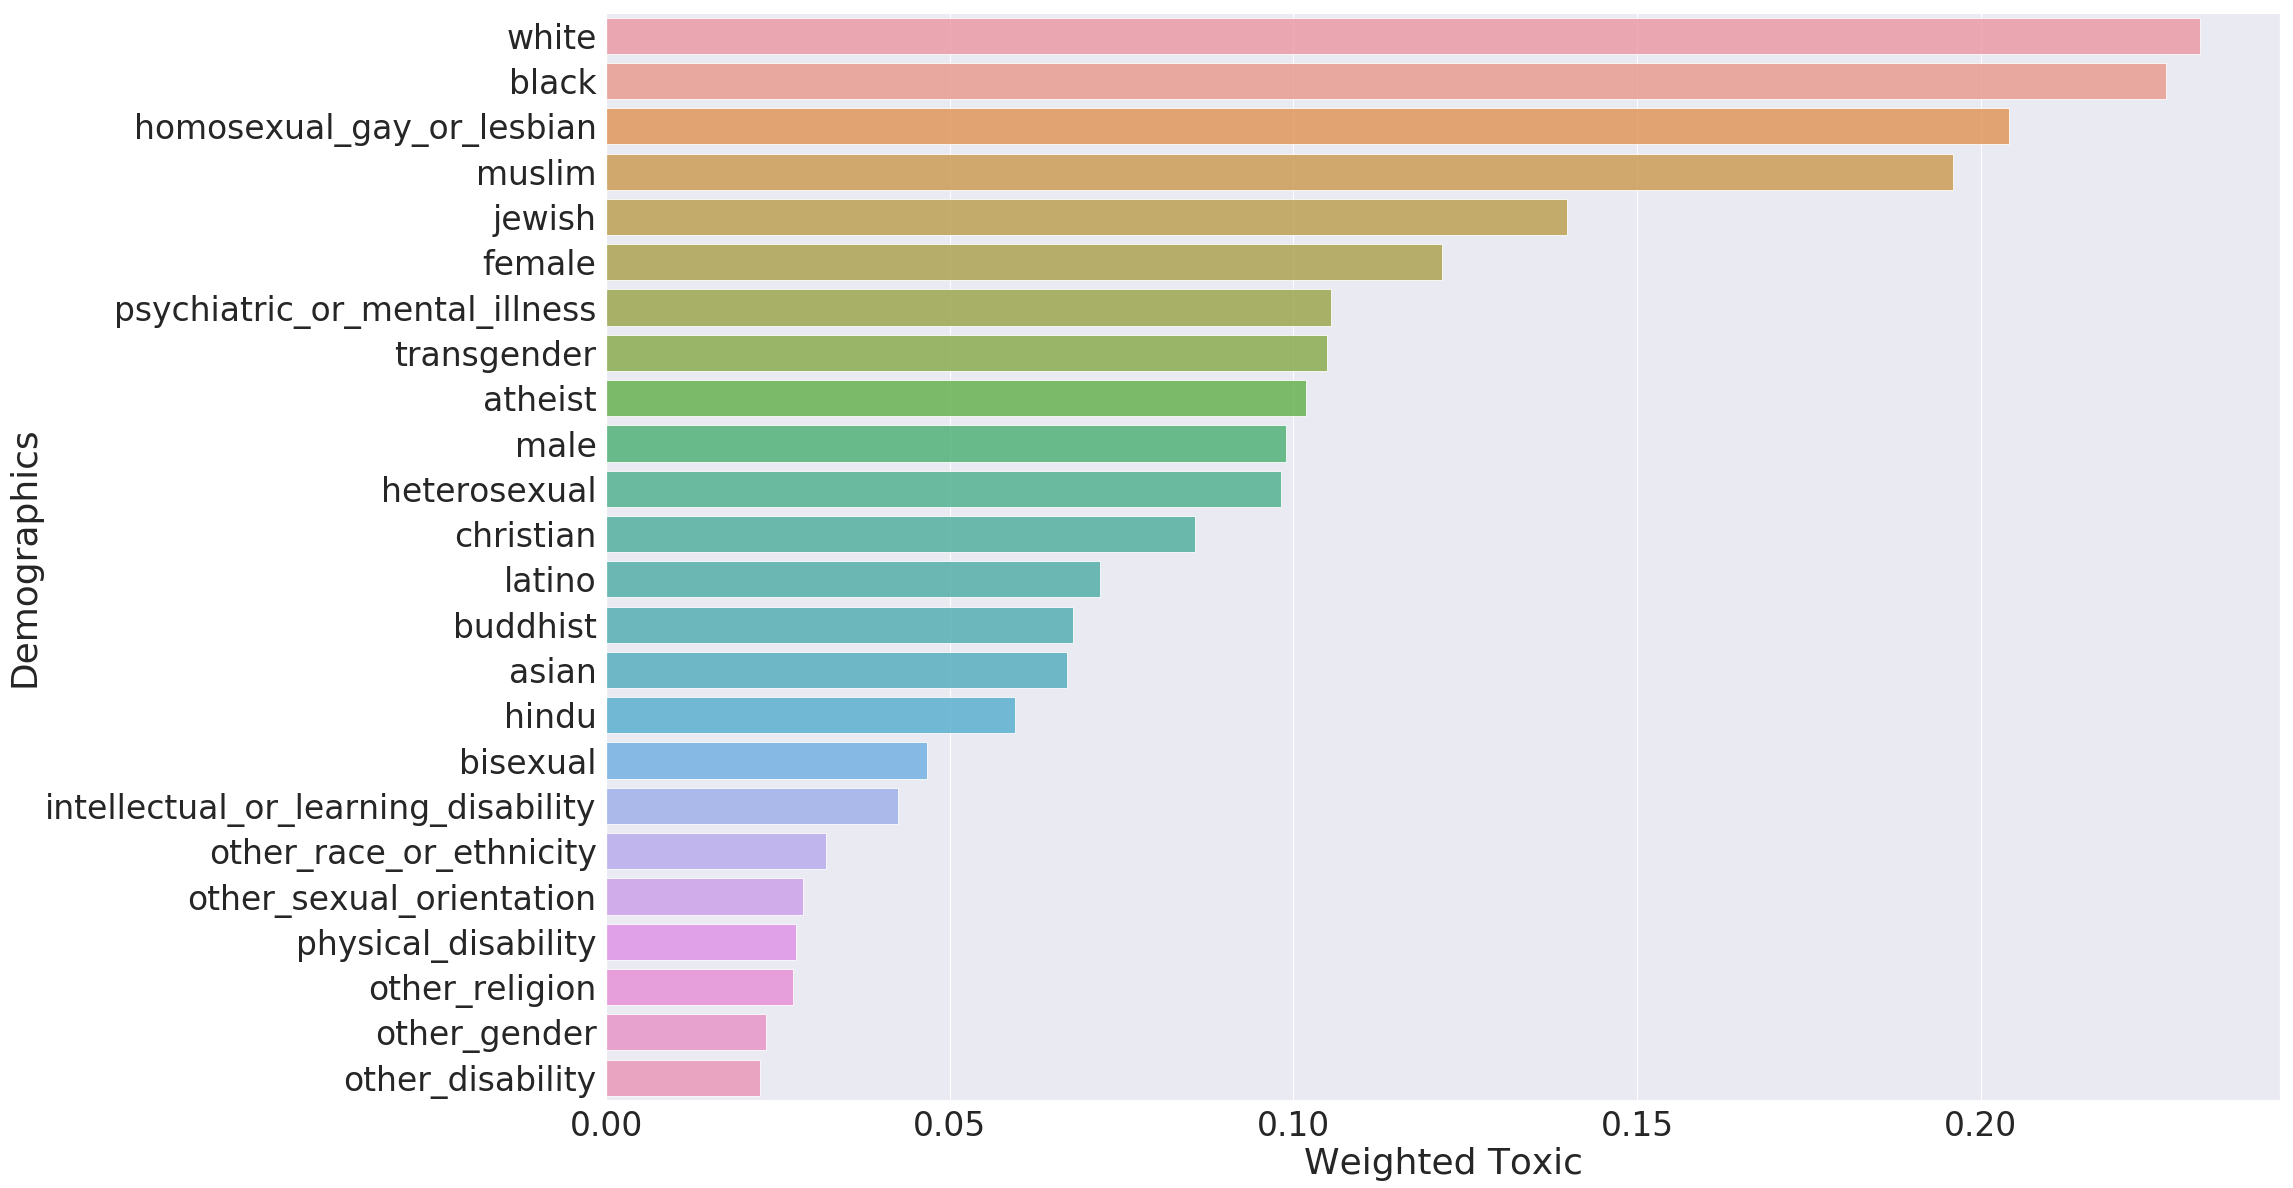

In [18]:
demographics = train.loc[:, ['target']+list(train)[slice(8,32)]].dropna()
weighted_toxic = demographics.iloc[:, 1:].multiply(demographics.iloc[:, 0], axis="index").sum()/demographics.iloc[:, 1:][demographics.iloc[:, 1:]>0].count()
weighted_toxic = weighted_toxic.sort_values(ascending=False)
plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = weighted_toxic.values, y = weighted_toxic.index, alpha=0.8)
plt.ylabel('Demographics')
plt.xlabel('Weighted Toxic')

In [19]:
word_length = train['comment_text'].str.split().apply(len).value_counts().sort_index()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


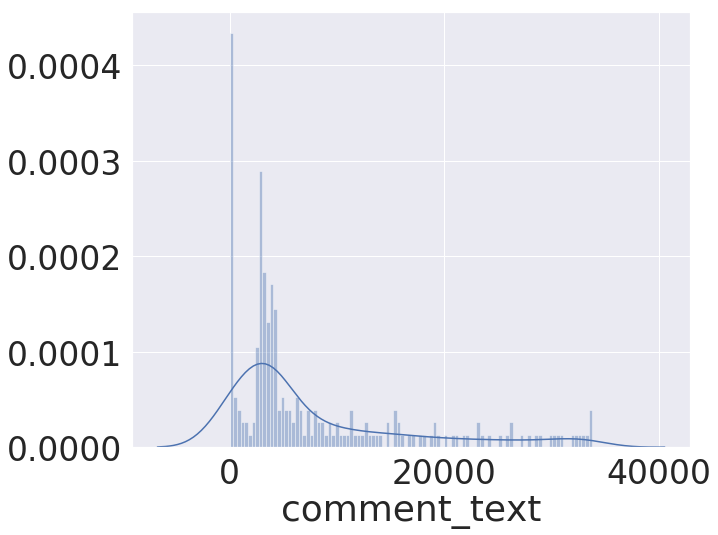

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(word_length, bins=100, ax=ax)

## Train

In [23]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import LearningRateScheduler


EMBEDDING_FILES = [
    '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec',
    '../input/glove840b300dtxt/glove.840B.300d.txt'
]

NUM_MODELS = 2
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 220


In [32]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)


def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix
    

def build_model(embedding_matrix, num_aux_targets):
    words = Input(shape=(MAX_LEN,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model
    

def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [25]:
x_train = preprocess(train['comment_text'])
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = preprocess(test['comment_text'])

In [28]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

In [30]:
x_train.shape

(1804874, 220)

In [36]:
len(tokenizer.word_index)

327575

In [34]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'and': 3,
 'of': 4,
 'a': 5,
 'is': 6,
 'in': 7,
 'that': 8,
 'it': 9,
 'i': 10,
 'you': 11,
 'for': 12,
 's': 13,
 'are': 14,
 'not': 15,
 'be': 16,
 't': 17,
 'on': 18,
 'have': 19,
 'they': 20,
 'this': 21,
 'with': 22,
 'as': 23,
 'was': 24,
 'or': 25,
 'we': 26,
 'he': 27,
 'but': 28,
 'if': 29,
 'all': 30,
 'what': 31,
 'will': 32,
 'their': 33,
 'by': 34,
 'who': 35,
 'so': 36,
 'from': 37,
 'your': 38,
 'at': 39,
 'no': 40,
 'can': 41,
 'do': 42,
 'people': 43,
 'would': 44,
 'about': 45,
 'has': 46,
 'there': 47,
 'an': 48,
 'more': 49,
 'his': 50,
 'one': 51,
 'just': 52,
 'like': 53,
 'trump': 54,
 'out': 55,
 'when': 56,
 'up': 57,
 'don': 58,
 'our': 59,
 'how': 60,
 'them': 61,
 'my': 62,
 'get': 63,
 'should': 64,
 'than': 65,
 'us': 66,
 'been': 67,
 'were': 68,
 'only': 69,
 'time': 70,
 'any': 71,
 'some': 72,
 'other': 73,
 'because': 74,
 'now': 75,
 'think': 76,
 'those': 77,
 'why': 78,
 'many': 79,
 'know': 80,
 'good': 81,
 'then': 82,
 'wh

In [33]:
embedding_matrix = np.concatenate(
    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)

In [35]:
embedding_matrix.shape

(327576, 600)

In [ ]:
checkpoint_predictions = []
weights = []

for model_idx in range(NUM_MODELS):
    model = build_model(embedding_matrix, y_aux_train.shape[-1])
    for global_epoch in range(EPOCHS):
        model.fit(
            x_train,
            [y_train, y_aux_train],
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=2,
            callbacks=[
                LearningRateScheduler(lambda epoch: 1e-3 * (0.6 ** global_epoch))
            ]
        )
        checkpoint_predictions.append(model.predict(x_test, batch_size=2048)[0].flatten())
        weights.append(2 ** global_epoch)

predictions = np.average(checkpoint_predictions, weights=weights, axis=0)

submission = pd.DataFrame.from_dict({
    'id': test['id'],
    'prediction': predictions
})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1
 - 774s - loss: 0.2381 - dense_3_loss: 0.1307 - dense_4_loss: 0.1074
Epoch 1/1
 - 770s - loss: 0.2179 - dense_3_loss: 0.1151 - dense_4_loss: 0.1027
Epoch 1/1
 - 771s - loss: 0.2116 - dense_3_loss: 0.1098 - dense_4_loss: 0.1018
Epoch 1/1
 - 771s - loss: 0.2072 - dense_3_loss: 0.1060 - dense_4_loss: 0.1013
Epoch 1/1
 - 774s - loss: 0.2388 - dense_7_loss: 0.1312 - dense_8_loss: 0.1076
Epoch 1/1
 - 772s - loss: 0.2179 - dense_7_loss: 0.1152 - dense_8_loss: 0.1027


In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
model.predict(x_train, batch_size=2048)[0].flatten()

In [ ]:
MODEL_NAME = 'my_model'
train[MODEL_NAME] = model.predict(pad_text(validate_df[TEXT_COLUMN], tokenizer))[:, 1]

## Metrics

In [ ]:
# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']


In [ ]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive


def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns, MODEL_NAME, 'target')
bias_metrics_df
a